In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions.multi_objective import BraninCurrin


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
NOISE_SE = torch.tensor([0., 0.], **tkwargs)

In [3]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def normalize_y(y_obs):
    y_mean = y_obs.mean()
    y_std = y_obs.std()
    return (y_obs - y_mean) / y_std


def unnormlize_y(y_obs, y_data):
    y_mean = y_obs.mean()
    y_std = y_obs.std()
    return y_data * y_std + y_mean


In [4]:
# define problem
problem = BraninCurrin(negate=True).to(**tkwargs)
init_x, init_y, init_y_true = generate_initial_data(problem, 20)

In [5]:
def plot_objective(problem, problem_name, obs, ax, fig, num_samples: int = 100):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.t()[0], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)

    z = problem(input_data)[:, 0 if problem_name == "branin" else 1]
    countourset = ax.contourf(
        xx,
        yy,
        z.reshape(xx.shape),
        cmap='bone'
    )
    ax.scatter(*obs, marker='x', color='k')

    # ax.legend(frameon=True)    
    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(problem_name)
    clb.ax.set_title('z')

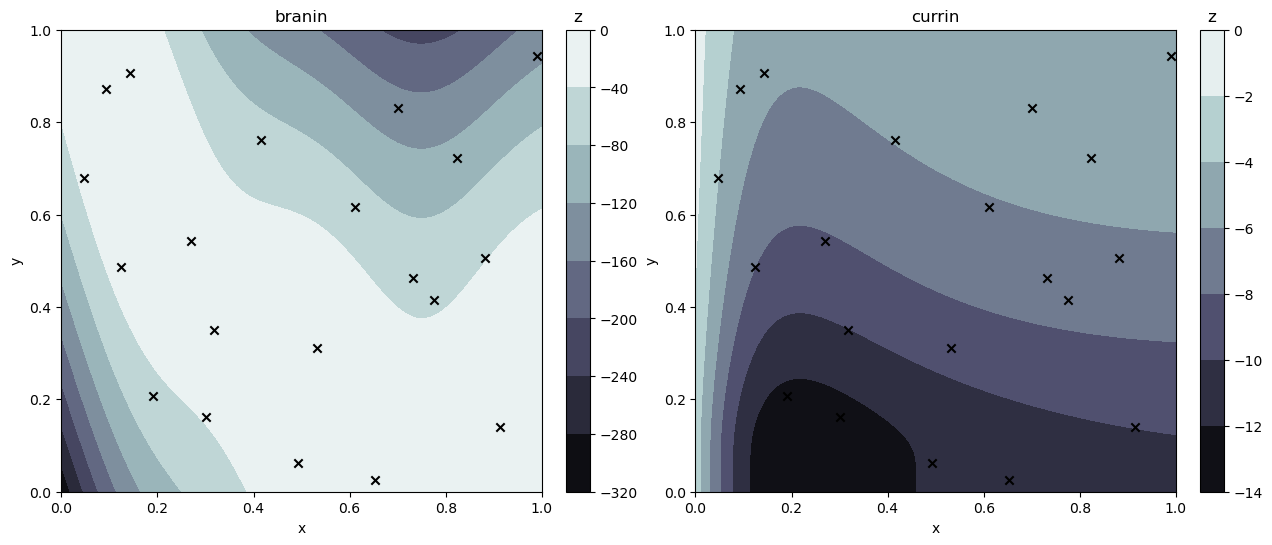

In [6]:
fig = plt.figure(figsize=(15, 6))
ax_branin = fig.add_subplot(121)
plot_objective(problem=problem, problem_name='branin', ax=ax_branin, obs=init_x.t(), fig=fig)
ax_currin = fig.add_subplot(122)
plot_objective(problem=problem, problem_name='currin', ax=ax_currin, obs=init_x.t(), fig=fig)
plt.show()

In [7]:
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 20
    ),
    np.linspace(
        *problem.bounds.t()[0], 20
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data)

## GPs

In [8]:
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

In [9]:
gp_models = []

for i in range(init_y_true.shape[-1]):
    gp_models.append(
        SingleTaskGP(
            init_x, init_y_true[..., i:i+1], outcome_transform=Standardize(m=1)
        )
    )

gp_model = ModelListGP(*gp_models)
mll = SumMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (outcome_transform): Standardize()
      )
    )
    (likelihood): LikelihoodList

In [10]:
with torch.no_grad():
    means = gp_model.posterior(input_data).mean
branin_means, currin_means = means[:, 0], means[:, 1]

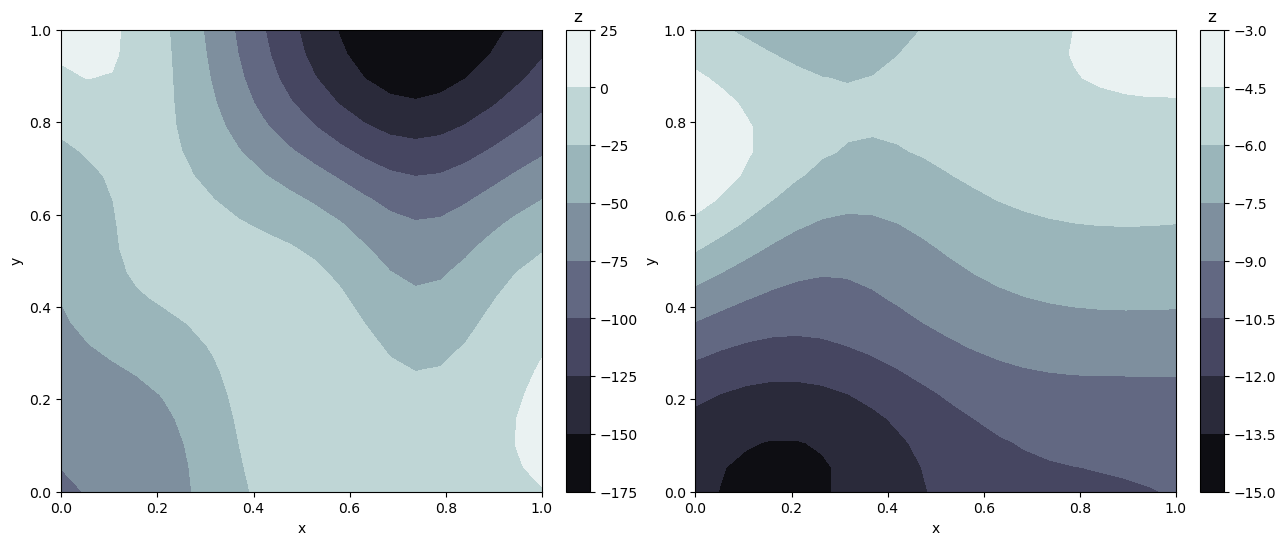

In [11]:
fig = plt.figure(figsize=(15, 6))
ax_branin = fig.add_subplot(121)
ax_currin = fig.add_subplot(122)

for ax, means in zip([ax_branin, ax_currin], [branin_means, currin_means]):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    countourset = ax.contourf(
        xx,
        yy,
        means.reshape(xx.shape),
        cmap='bone'
    )
    # ax.scatter(*obs, marker='x', color='k')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.set_title('')
    clb.ax.set_title('z')

plt.show()

## PFNs

In [12]:
from optimizers.pfns.scripts.acquisition_functions import TransformerBOMethod

In [13]:
# PFNs parameters
device = 'cpu:0'
hebo_plus_model = "/home/paj7rng/workspace/mobo_experiments/optimizers/pfns/final_models/model_hebo_morebudget_9_unused_features_3_whole_model.pt"
pfn_model = torch.load(hebo_plus_model)
# for correctly specified search spaces (e.g. correctly applied log transformations)
pfn_bo = TransformerBOMethod(pfn_model, device=device, acq_function='mean', apply_power_transform=False, znormalize=False,)

In [14]:
# for branin
_, branin_means = pfn_bo.observe_and_suggest(
    X_obs=init_x, y_obs=normalize_y(init_y_true[:, 0:1]), X_pen=input_data, return_actual_ei=True,
)
branin_means = unnormlize_y(init_y_true[:, 0:1], branin_means)

# for currin
_, currin_means = pfn_bo.observe_and_suggest(
    X_obs=init_x, y_obs=normalize_y(init_y_true[:, 1:2]), X_pen=input_data, return_actual_ei=True
)
currin_means = unnormlize_y(init_y_true[:, 1:2], currin_means)

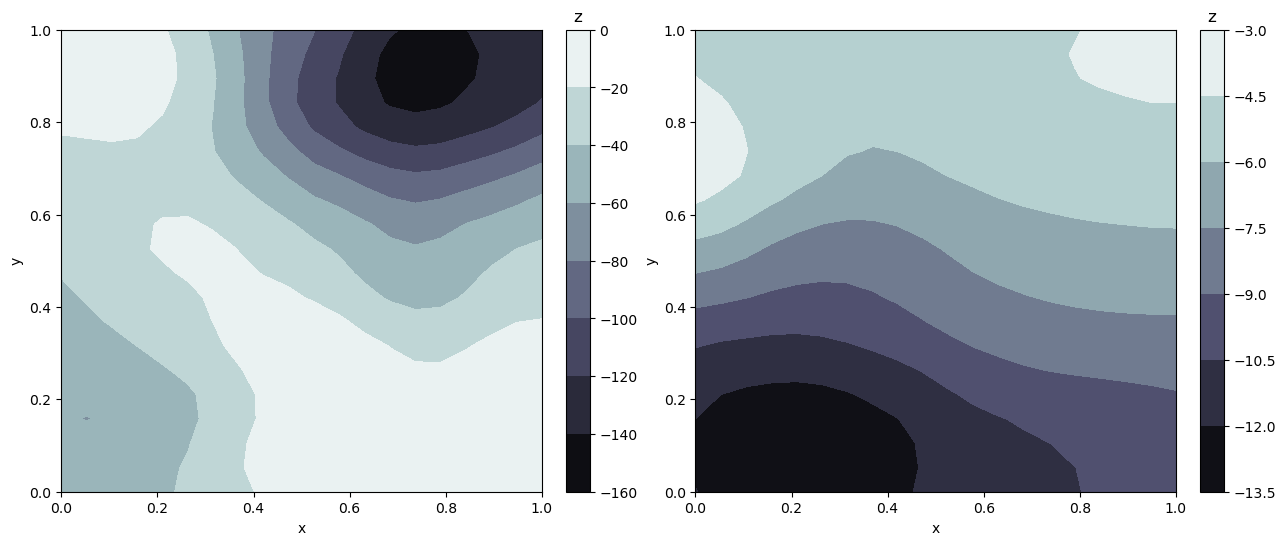

In [15]:
fig = plt.figure(figsize=(15, 6))
ax_branin = fig.add_subplot(121)
ax_currin = fig.add_subplot(122)

for ax, means in zip([ax_branin, ax_currin], [branin_means, currin_means]):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    countourset = ax.contourf(
        xx,
        yy,
        means.reshape(xx.shape),
        cmap='bone'
    )
    # ax.scatter(*obs, marker='x', color='k')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.set_title('')
    clb.ax.set_title('z')

plt.show()